In [1]:
import array
import os
import struct

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200
import numpy as np
import seaborn as sns
from scipy import signal

from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm

In [2]:
def read_block(fl):
    # read header of block
    # read magic number + sampling rate + number of samples
    header_bytes = fl.read(12)
    header = struct.unpack(">III", header_bytes)
    magic_number, sample_rate, num_samples = header
    if hex(magic_number) != "0xdeadbeef":
        raise Exception("Invalid magic number " + str(magic_number))

    bytes_to_read = num_samples * 2
    sample_bytes = fl.read(bytes_to_read)
    if len(sample_bytes) < bytes_to_read:
        raise Exception("Block has fewer samples than expected")

    samples = array.array("h", sample_bytes)
    samples.byteswap()

    return samples

In [3]:
blocks = []

with open("dish_washer_audio_1sec.bin", "rb") as fl:
    fl.seek(0, os.SEEK_END)
    fl_size = fl.tell() / 1024 / 1024 # bytes to megabytes
    print(fl_size)
    fl.seek(0, os.SEEK_SET)
    while True:
        try:
            block = read_block(fl)
            blocks.append(block)
        except:
            break

with open("dish_washer_audio_3sec-1.bin", "rb") as fl:
    fl.seek(0, os.SEEK_END)
    fl_size = fl.tell() / 1024 / 1024 # bytes to megabytes
    print(fl_size)
    fl.seek(0, os.SEEK_SET)

    while True:
        try:
            block = read_block(fl)
            blocks.append(block)
        except:
            break

with open("dish_washer_audio_3sec-2.bin", "rb") as fl:
    fl.seek(0, os.SEEK_END)
    fl_size = fl.tell() / 1024 / 1024 # bytes to megabytes
    print(fl_size)
    fl.seek(0, os.SEEK_SET)

    while True:
        try:
            block = read_block(fl)
            blocks.append(block)
        except:
            break

with open("dish_washer_audio_3sec-3.bin", "rb") as fl:
    fl.seek(0, os.SEEK_END)
    fl_size = fl.tell() / 1024 / 1024 # bytes to megabytes
    print(fl_size)
    fl.seek(0, os.SEEK_SET)

    n = 0
    while True:
        try:
            block = read_block(fl)
            blocks.append(block)
            n += 1
        except:
            break
    print(n)

n_blocks = len(blocks)
print(n_blocks)

35.00914001464844
824.6220779418945
99.1596794128418
348.9776725769043
3041
12012


In [4]:
print(len(blocks))

12012


In [5]:
block_sizes = [len(b) for b in blocks]
print(block_sizes[:10])

[20096, 20032, 20032, 20032, 20032, 20032, 20032, 20032, 20032, 20032]


In [6]:
block_end = 2 ** 14
block_tails = [b[-block_end:] for b in blocks]

In [7]:
# 1 - dish washer on, 0 - dish washer off
labels = np.zeros(n_blocks)
labels[700 : 840] = 1.0
labels[6255 : 6405] = 1.0
labels[7930 : 8080] = 1.0
labels[8230 : 8355] = 1.0
labels[10938 : 11068] = 1.0

block_spectra_list = [np.abs(np.fft.rfft(b, norm="forward")) for b in block_tails]
block_spectra = np.vstack(block_spectra_list)
print(n_blocks, block_spectra.shape)

features = block_spectra

print(features.shape)

12012 (12012, 8193)
(12012, 8193)


In [8]:
positive_spectra = block_spectra[labels == 1.0]
negative_spectra = block_spectra[labels == 0.0]

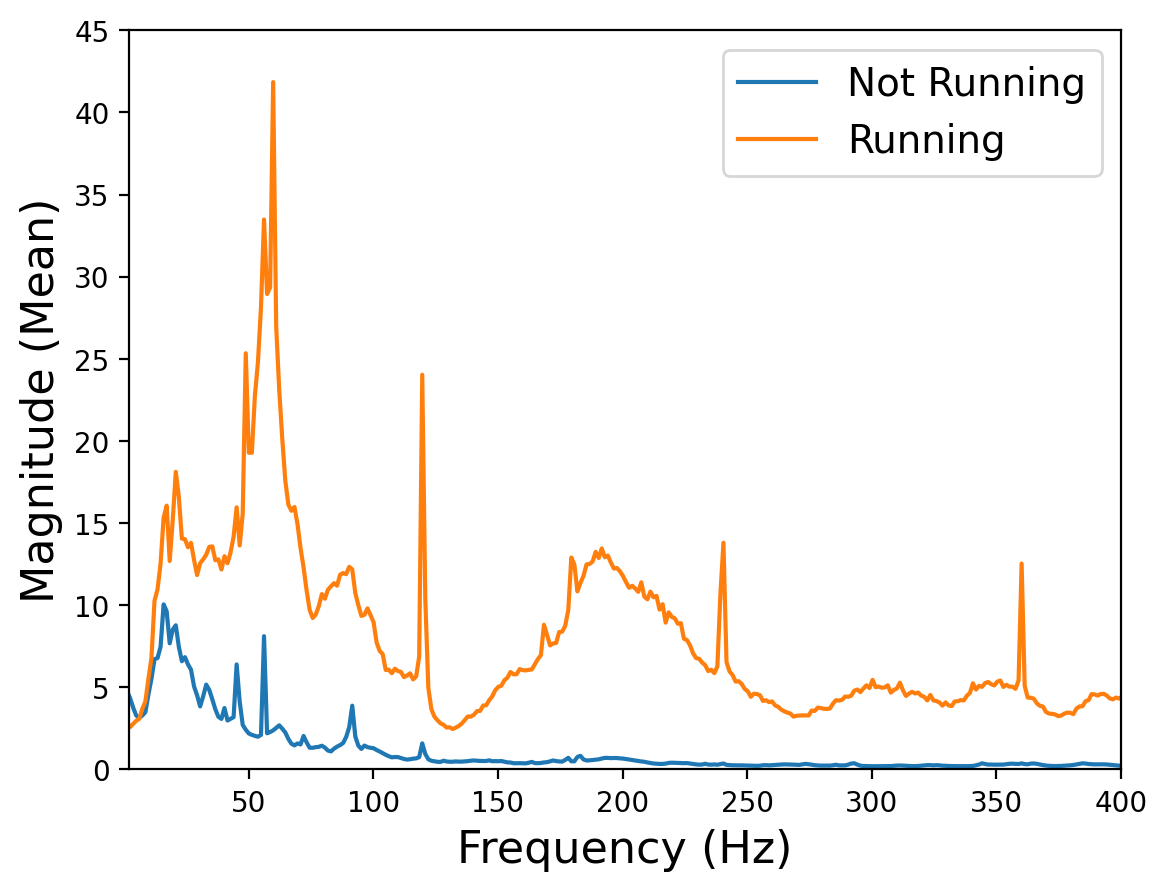

In [9]:
plt.plot(np.fft.rfftfreq(block_end, d=1/20000.), negative_spectra.mean(axis=0), label = "Not Running")
plt.plot(np.fft.rfftfreq(block_end, d=1/20000.), positive_spectra.mean(axis=0), label = "Running")
plt.xlim([2, 400])
plt.ylim([0, 45])
plt.xlabel("Frequency (Hz)", fontsize=16)
plt.ylabel("Magnitude (Mean)", fontsize=16)
plt.legend(fontsize=14)
plt.savefig("spectra_means.png")

In [10]:
for f, m in zip(np.fft.rfftfreq(block_end, d=1/20000.), positive_spectra.mean(axis=0)):
    if f >= 400:
        break
    print(f, m)

0.0 128.3544509997471
1.220703125 2.5725596910138924
2.44140625 2.582517503454147
3.662109375 2.7783566524346126
4.8828125 2.96129792121812
6.103515625 3.0818741836628636
7.32421875 3.6965364058242405
8.544921875 4.130974735435539
9.765625 5.5206177240523395
10.986328125 6.778105115342562
12.20703125 10.26319026353023
13.427734375 10.967116697659817
14.6484375 12.535963379426306
15.869140625 15.331192803436801
17.08984375 16.05997847804256
18.310546875 12.68763194878694
19.53125 15.19621713782406
20.751953125 18.115080990022452
21.97265625 16.585925879856287
23.193359375 14.048793387810651
24.4140625 14.021018870571014
25.634765625 13.528910073465283
26.85546875 13.795875457869347
28.076171875 12.754963161511906
29.296875 11.833504350485862
30.517578125 12.552758037161226
31.73828125 12.792165410810341
32.958984375 13.071129732630977
34.1796875 13.55003099231562
35.400390625 13.579811854419559
36.62109375 12.735399707603268
37.841796875 12.785097388613377
39.0625 12.170144925132789
40.

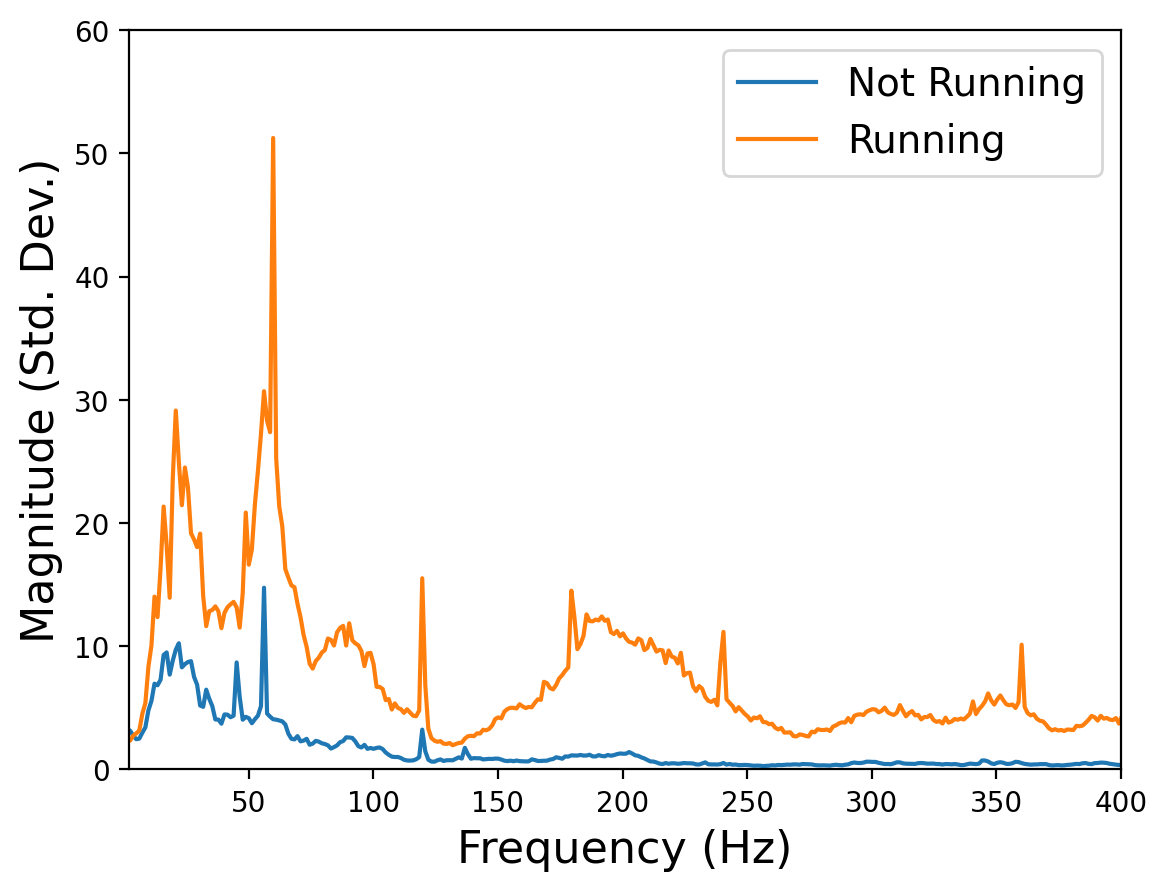

In [11]:
plt.plot(np.fft.rfftfreq(block_end, d=1/20000.), negative_spectra.std(axis=0), label = "Not Running")
plt.plot(np.fft.rfftfreq(block_end, d=1/20000.), positive_spectra.std(axis=0), label = "Running")
plt.xlim([2, 400])
plt.ylim([0, 60])
plt.xlabel("Frequency (Hz)", fontsize=16)
plt.ylabel("Magnitude (Std. Dev.)", fontsize=16)
plt.legend(fontsize=14)
plt.savefig("spectra_std.png")

In [12]:
block_spectra_list = [np.fft.rfft(b, norm="forward") for b in block_tails]
block_spectra = np.vstack(block_spectra_list)

positive_spectra = block_spectra[labels == 1.0]

In [13]:
block_spectra_list[0]

array([-1.64792969e+02 +0.j        ,  4.87304894e+00 +9.58903139j,
       -1.93276212e+01-15.07849386j, ...,  4.95683749e-02 +0.1077421j ,
        1.03866480e-01 +0.10146955j,  1.06689453e-01 +0.j        ])

In [14]:
positive_spectra[0]

array([-1.24131714e+02+0.j        ,  5.11662352e+00-3.68511275j,
       -2.32801713e+00+2.05530822j, ...,  5.19026799e-02+0.03458277j,
       -3.13291940e-02-0.04570874j, -1.09741211e-01+0.j        ])

In [15]:
positive_spectra.shape

(695, 8193)

In [16]:
positive_spectra.real.std(axis=0)

array([4.02207715, 2.82559132, 2.69736072, ..., 0.04406088, 0.04735185,
       0.06335398])

In [17]:
positive_spectra.imag.std(axis=0) * 1.0j

array([0.+0.j        , 0.+1.93901031j, 0.+2.20916707j, ...,
       0.+0.04535317j, 0.+0.04649618j, 0.+0.j        ])

In [18]:
positive_spectra_avg = positive_spectra.real.std(axis=0) + positive_spectra.imag.std(axis=0) * 1.0j

positive_spectra_avg.shape

positive_spectra_avg

array([4.02207715+0.j        , 2.82559132+1.93901031j,
       2.69736072+2.20916707j, ..., 0.04406088+0.04535317j,
       0.04735185+0.04649618j, 0.06335398+0.j        ])

Text(0, 0.5, 'Amplitude')

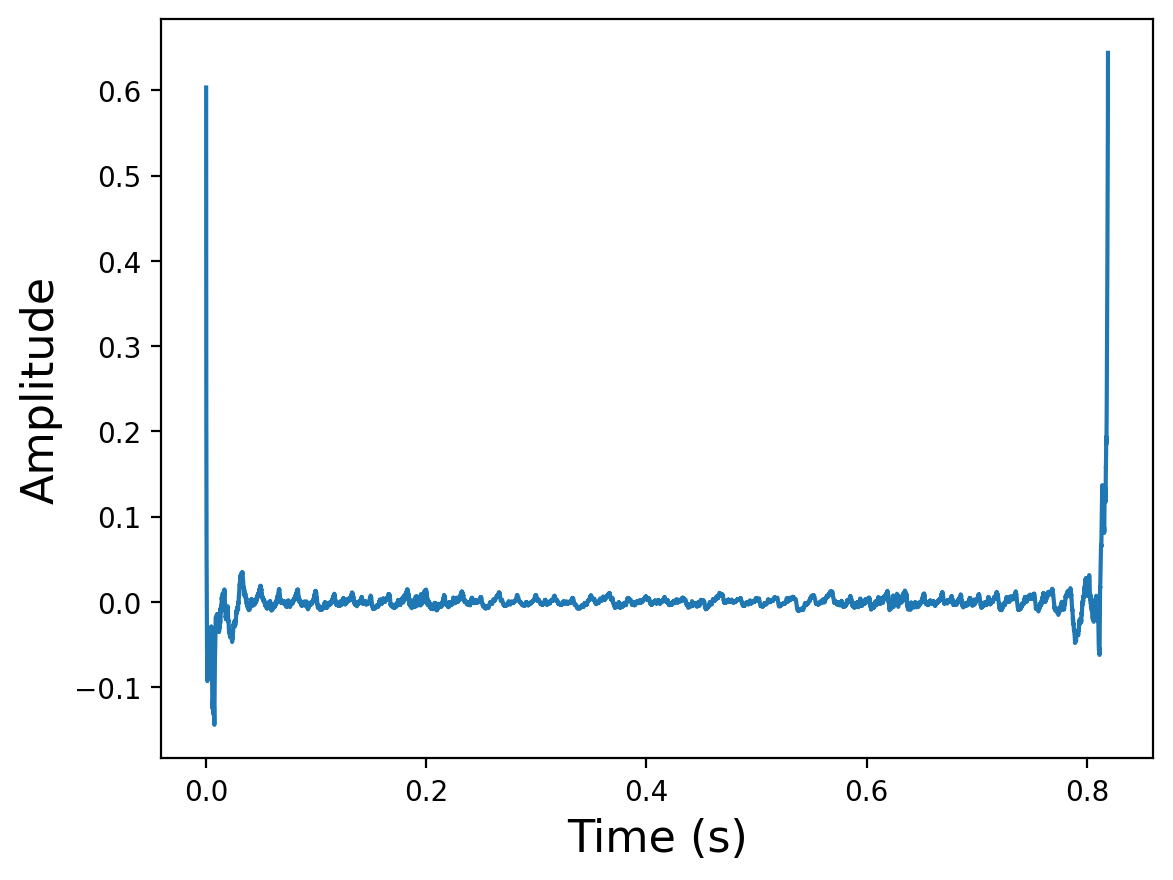

In [19]:
avg_signal = np.fft.irfft(positive_spectra_avg)
times = np.array(range(1, len(avg_signal) + 1)) * 1 / 20000.
plt.plot(times, avg_signal)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)

In [20]:
block_spectra_list = [np.fft.rfft(b, norm="forward") for b in block_tails]
block_spectra = np.vstack(block_spectra_list)

negative_spectra = block_spectra[labels == 0.0]

negative_spectra_avg = negative_spectra.real.std(axis=0) + negative_spectra.imag.std(axis=0) * 1.0j

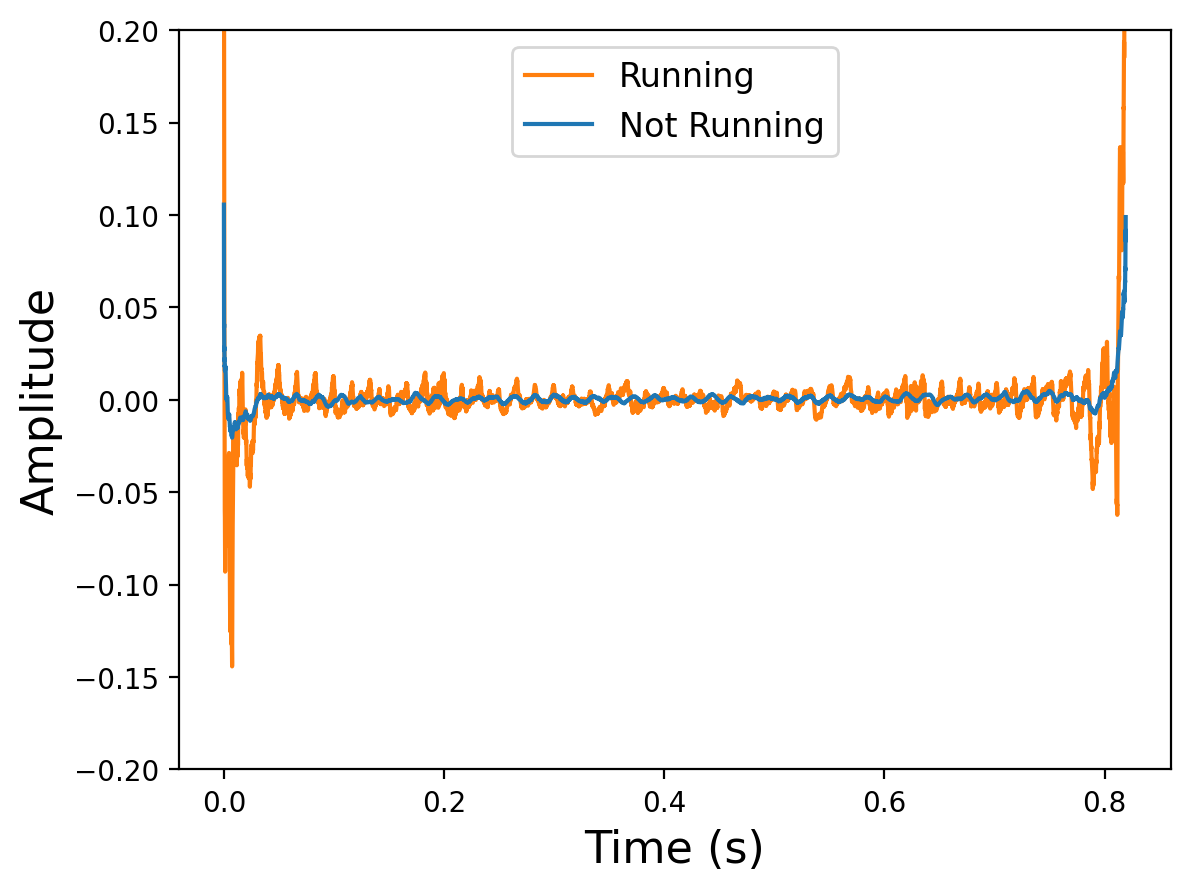

In [21]:
neg_avg_signal = np.fft.irfft(negative_spectra_avg)
pos_avg_signal = np.fft.irfft(positive_spectra_avg)
times = np.array(range(1, len(neg_avg_signal) + 1)) * 1 / 20000.
plt.plot(times, pos_avg_signal, label = "Running", color="tab:orange")
plt.plot(times, neg_avg_signal, label = "Not Running", color="tab:blue")
plt.legend(fontsize=12, loc="upper center")
plt.ylim([-0.2, 0.2])
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)
plt.savefig("reconstructed-signals.png")